C:\ProgramData\Anaconda2\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


Loading...
Training...
epoch: 0 real: 0.882318975047 fake: 0.89354666772 time: 212.849999905


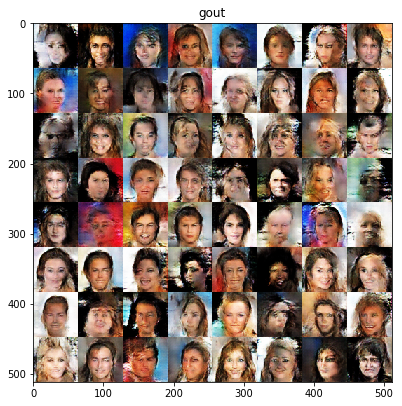

In [ ]:
from __future__ import print_function
import mxnet as mx
import numpy as np
import time
from matplotlib import pyplot as plt
from datetime import datetime

ctx = mx.gpu(0)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M') # 设置输出时间格式
plt.rcParams['figure.figsize'] = (6.6, 6.6) # 增大图像的显示尺寸

img_path = 'data/celeba.rec' # 训练图像
img_size = 64 # 图像尺寸
nc = 3 # 图像的通道数，3代表彩色

Z = 100 # 编码维数
batch_size = 64 # 批大小
ndf = 64 # D网络的大小参数
ngf = 64 # G网络的大小参数

# 如需继续训练可设置这里
loadG = None # 例如"G_2017_09_11-07_38"
loadD = None # 例如"D_2017_09_11-07_38"

check_point_period = 1 # 每隔多少epoch保存模型

# 训练参数
lr_G = 0.0002
lr_D = 0.0002
beta1_G = 0.5
beta1_D = 0.5
wd_G = 0
wd_D = 0

leaky_slope = 0.2 # 负轴泄露程度

# 定义网络所需的辅助函数
def Leaky(s, name):
    return mx.sym.LeakyReLU(s, act_type='prelu', slope=leaky_slope, name=name)

def BatchNorm(s, name): # 设置fix_gamma为True有可能改善模式坍塌
    return mx.sym.BatchNorm(s, name=name, fix_gamma=True, eps=1e-5 + 1e-12)

def Upsize2x(s, name, num_filter):
    return mx.sym.Deconvolution(s, name=name, kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=num_filter)

def Downsize2x(s, name, num_filter):
    return mx.sym.Convolution(s, name=name, kernel=(4,4), stride=(2,2), pad=(1,1), num_filter=num_filter)

def Upsize2x_BN_Act(s, name, num_filter):
    s = Upsize2x(s, name=name, num_filter=num_filter)
    s = BatchNorm(s, name=name+'_bn')
    s = Leaky(s, name=name+'_act')
    return s

def Downsize2x_BN_Act(s, name, num_filter):
    s = Downsize2x(s, name=name, num_filter=num_filter)
    s = BatchNorm(s, name=name+'_bn')
    s = Leaky(s, name=name+'_act')
    return s

# 定义G和D网络
def make_dcgan_sym(ngf, ndf, nc):

    Gnet = mx.sym.Variable('rand')
    
    Gnet = mx.sym.Deconvolution(Gnet, name='g1', kernel=(4,4), num_filter=ngf*8) # 增大至4x4
    Gnet = BatchNorm(Gnet, name='g1_bn')
    Gnet = Leaky(Gnet, name='g1_act')
    
    Gnet = Upsize2x_BN_Act(Gnet, name='g2', num_filter=ngf*4) # 增大至8x8
    Gnet = Upsize2x_BN_Act(Gnet, name='g3', num_filter=ngf*2) # 增大至16x16
    Gnet = Upsize2x_BN_Act(Gnet, name='g4', num_filter=ngf) # 增大至32x32
    
    Gnet = Upsize2x(Gnet, name='g5', num_filter=nc) # 增大至64x64
    Gnet = mx.sym.Activation(Gnet, act_type='tanh', name='gout') # 经过tanh后输出，范围为-1到1

    ###################################
    
    Dnet = mx.sym.Variable('data')

    Dnet = Downsize2x(Dnet, name='d1', num_filter=ndf) # 缩小至32x32
    Dnet = Leaky(Dnet, name='d1_act')
   
    Dnet = Downsize2x_BN_Act(Dnet, name='d2', num_filter=ndf*2) # 缩小至16x16
    Dnet = Downsize2x_BN_Act(Dnet, name='d3', num_filter=ndf*4) # 缩小至8x8
    Dnet = Downsize2x_BN_Act(Dnet, name='d4', num_filter=ndf*8) # 缩小至4x4
   
    Dnet = mx.sym.Convolution(Dnet, name='d5', kernel=(4,4), num_filter=1) # 缩小至1x1
    Dnet = mx.sym.Flatten(Dnet)
    Dnet = mx.sym.LogisticRegressionOutput(Dnet, label=mx.sym.Variable('label'), name='dloss') # 做Logistic回归
    
    # 研究人员认为G的输出层和D的输入层可能不应该加BN，读者也可自行实验
    
    return Gnet, Dnet

# 提供编码z的迭代器
class RandIter(mx.io.DataIter):
    def __init__(self, batch_size, ndim):
        self.batch_size = batch_size
        self.ndim = ndim
        self.provide_data = [('rand', (batch_size, ndim, 1, 1))]
        self.provide_label = []

    def iter_next(self):
        return True

    def getdata(self): # 从随机采样得出z
        return [mx.nd.random_normal(0.0, 1.0, shape=(self.batch_size, self.ndim, 1, 1))]

# 提供图像x的迭代器
class ImageIter(mx.io.DataIter):
    def __init__(self, path, batch_size, data_shape):
        self.internal = mx.io.ImageRecordIter(
            path_imgrec = path,
            data_shape  = data_shape,
            batch_size  = batch_size,
            shuffle = True,
            resize = img_size,
            min_crop_size = img_size,
            max_crop_size = img_size,
            min_img_size = img_size,
            max_img_size = img_size,
            rand_crop   = False,
            rand_mirror = True)
        self.provide_data = [('data', (batch_size,) + data_shape)]
        self.provide_label = []

    def reset(self):
        self.internal.reset()

    def iter_next(self):
        return self.internal.iter_next()

    def getdata(self):
        data = self.internal.getdata()
        data = data * (2.0/255.0) - 1.0 # 将图像数据归一化到-1与1之间
        return [data]

# 用于输出图像的辅助函数
def fill_buf(buf, i, img, shape):
    n = buf.shape[0]/shape[1]
    m = buf.shape[1]/shape[0]
    sx = (i%m)*shape[0]
    sy = (i/m)*shape[1]
    buf[sy:sy+shape[1], sx:sx+shape[0], :] = img

# 用于输出图像的函数
def visual(title, X):
    X = X.transpose((0, 2, 3, 1))
    X = np.clip((X+1.0)*255.0/2.0, 0, 255).astype(np.uint8)
    n = np.ceil(np.sqrt(X.shape[0]))
    buff = np.zeros((int(n*X.shape[1]), int(n*X.shape[2]), int(X.shape[3])), dtype=np.uint8)
    for i, img in enumerate(X):
        fill_buf(buff, i, img, X.shape[1:3])
    plt.imshow(buff)
    plt.title(title)
    plt.show()

# 训练主程序
if __name__ == '__main__':
    
    print('Loading...')
    
    # 定义网络架构和迭代器
    symG, symD = make_dcgan_sym(ngf, ndf, nc)
    train_iter = ImageIter(img_path, batch_size, (nc, img_size, img_size))
    rand_iter = RandIter(batch_size, Z)
    
    label = mx.nd.zeros((batch_size, ), ctx=ctx) # 训练用的标签
    
    # ============= 定义G网络模组 =============

    modG = mx.mod.Module(symbol=symG, data_names=('rand',), label_names=None, context=ctx)
    modG.bind(data_shapes=rand_iter.provide_data, inputs_need_grad=True)

    if loadG: # 从文件读入参数，或初始化参数
        modG.init_params(initializer=mx.init.Load(loadG))
    else:
        modG.init_params(initializer=mx.init.MSRAPrelu(slope=leaky_slope))

    modG.init_optimizer(
        optimizer='adam',
        optimizer_params={
            'learning_rate': lr_G,
            'wd': wd_G,
            'beta1': beta1_G,
        })
    
    # ============= 定义D网络模组 =============
    
    modD = mx.mod.Module(symbol=symD, data_names=('data',), label_names=('label',), context=ctx)
    modD.bind(data_shapes=train_iter.provide_data,
              label_shapes=[('label', (batch_size,))],
              inputs_need_grad=True)
    
    if loadD: # 从文件读入参数，或初始化参数
        modD.init_params(initializer=mx.init.Load(loadD))
    else:
        modD.init_params(initializer=mx.init.MSRAPrelu(slope=leaky_slope))

    modD.init_optimizer(
        optimizer='adam',
        optimizer_params={
            'learning_rate': lr_D,
            'wd': wd_D,
            'beta1': beta1_D,
        })

    # ============ 定义性能指标 ==============

    def facc(label, pred):
        pred = pred.ravel()
        label = label.ravel()
        return ((pred > 0.5) == label).mean()

    mReal = mx.metric.CustomMetric(facc)
    mFake = mx.metric.CustomMetric(facc)
    
    # ============= 开始训练 ===============
    
    print('Training...')
    start_time = time.time()
    
    for epoch in range(500): # 训练epoch数
        
        train_iter.reset()
        for t, batch in enumerate(train_iter):
            
            # 将batch中的x送入D，要求D输出1
            label[:] = 1 # 设置输出标签为1
            batch.label = [label]
            modD.forward(batch, is_train=True) # 将batch送入D
            modD.update_metric(mReal, [label]) # 更新性能指标
            modD.backward() # 反向传播
            # 将梯度保存待用
            gradD1 = [[grad.copyto(grad.context) for grad in grads] for grads in modD._exec_group.grad_arrays]
            
            # 将rbatch中的z送入G
            rbatch = rand_iter.next() # 需手工运行rand_iter，获得一批z
            modG.forward(rbatch, is_train=True) # 送入G
            outG = modG.get_outputs() # 获得输出

            # 将G生成的x送入D，要求D输出0
            label[:] = 0
            modD.forward(mx.io.DataBatch(outG, [label]), is_train=True) # 送入D
            modD.update_metric(mFake, [label]) # 更新性能指标
            modD.backward() # 反向传播

            # 将D在两种情况的梯度相加
            for i in range(len(gradD1)):
                for j in range(len(gradD1[i])):
                    modD._exec_group.grad_arrays[i][j] += gradD1[i][j] # 加上之前的梯度
            modD.update() # 更新D的参数
            
            # 调整G的参数，使D(G(z))更接近1
            label[:] = 1
            # is_train会影响BN，因此这里将is_train关闭，否则会重复更新BN的统计信息
            modD.forward(mx.io.DataBatch(outG, [label]), is_train=False) # 先对D做前向传播
            modD.backward() # 反向传播，获得D的梯度
            modG.backward(modD.get_input_grads()) # 将D对于输入的梯度送入G反向传播
            modG.update() # 更新G的参数
        
        # 输出epoch的信息
        print('epoch:', epoch, 'real:', mReal.get()[1], 'fake:', mFake.get()[1], 'time:', time.time()-start_time)
        
        start_time = time.time()
        mReal.reset()
        mFake.reset()

        visual('gout', outG[0].asnumpy()) # 输出epoch的图像

        if check_point_period > 0 and epoch % check_point_period == (check_point_period - 1): # 保存网络参数
            modG.save_params('G_%s-%04d.params'%(stamp, epoch))
            modD.save_params('D_%s-%04d.params'%(stamp, epoch))